In [3]:
import numpy as np
import pandas as pd
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX

from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.factory import get_problem, get_termination
from sklearn.ensemble import RandomForestRegressor
from pymoo.util.misc import stack

data = pd.read_excel("dataset/data.xlsx")
soil_params = ["N", "P", "K", "S", "Zn", "Cu", "Fe", "Mn", "B"]
crop_yields = ["BajraY", "WheatY", "MustardY", "BarleyY", "MoongY", "GuarY"]
X_soil = data[soil_params]
y = data[crop_yields]
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_soil.values, y.values)
crop_prices = {'BajraY': 26.25, 'WheatY': 24.25, 'MustardY': 59.50, 'BarleyY': 19.80, 'GuarY': 48.40, 'MoongY': 86.82}
max_price = max(crop_prices.values())
rabi_crops = ['WheatY', 'MustardY', 'BarleyY']  # Winter crops
kharif_crops = ['BajraY', 'GuarY', 'MoongY']    # Summer crops

crop_data = {}
for crop in crop_yields:
    price = crop_prices[crop]
    if 'Bajra' in crop:
        cp = 16.84
        water = 525
    elif 'Wheat' in crop:
        cp = 11.82
        water = 550
    elif 'Mustard' in crop:
        cp = 30.11
        water = 375
    elif 'Barley' in crop:
        cp = 12.39
        water = 300
    elif 'Guar' in crop:
        cp = 42.0  
        water = 300
    elif 'Moong' in crop:
        cp = 51.59
        water = 400
    else:
        cp = 0.0
        water = 0
        
    crop_data[crop] = {
        'SP': price,
        'CP': cp,
        'W': water,
        'D': price / max_price,
        'season': 'rabi' if crop in rabi_crops else 'kharif'
    }

rabi_mask = np.array([1 if crop_data[crop]['season'] == 'rabi' else 0 for crop in crop_yields])
kharif_mask = 1 - rabi_mask

class CropProblem(Problem):
    def __init__(self):
        super().__init__(n_var=6, n_obj=3, n_constr=2, xl=0.0, xu=1.0) 
        self.y_pred = rf_model.predict(X_soil.mean().values.reshape(1, -1))[0] 
        print("y_pred",self.y_pred) 
        self.obj_scaling = np.array([1e-5, 1e-4, 1e-3]) 
    
    def _evaluate(self, x, out, *args, **kwargs): 
        n_pop = x.shape[0]
        f = np.zeros((n_pop, 3))
        g = np.zeros((n_pop, 2)) 
        h = np.zeros((n_pop, 2))  
        for i in range(n_pop):
            sum_rabi = np.sum(x[i] * rabi_mask)
            sum_kharif = np.sum(x[i] * kharif_mask)
            profit = np.sum([x[i][j] * (crop_data[crop]['SP'] * self.y_pred[j] - crop_data[crop]['CP']) for j, crop in enumerate(crop_yields)])
            yield_ = np.sum(x[i] * self.y_pred)
            water = np.sum([x[i][j] * crop_data[crop]['W'] for j, crop in enumerate(crop_yields)])
            f[i] = [-profit * self.obj_scaling[0], -yield_ * self.obj_scaling[1], water * self.obj_scaling[2]]
            g[i] = [(sum_rabi - 1) - 1e-4, (sum_kharif - 1) - 1e-4]  # g is the inequality constraint, also the inequality constraints need to be less than equal to 0. Also they needed to be normalized so that each one have equal weightage.
            h[i] = [sum_rabi - 1, sum_kharif - 1]  # h is the equality constraint
        out["F"] = f 
        out["G"] = g
        out["H"] = h 

In [4]:
import random
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.5, eta=20),
    mutation=PM(eta=20),
    save_history=True,
    eliminate_duplicates=True
)
problem = CropProblem()
termination = get_termination("n_gen", 100)
res = minimize(problem, algorithm, termination, seed=343374524, verbose=True, save_history=True)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False

y_pred [ 855.11 3250.9  1209.2  3138.82  264.1   432.4 ]
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  1.062658632 |       1 |            - |            -
    2 |     200 |  0.00000E+00 |  0.457095367 |       5 |  0.875822520 |        ideal
    3 |     300 |  0.00000E+00 |  0.150636920 |      15 |  0.086073181 |        ideal
    4 |     400 |  0.00000E+00 |  0.023977087 |      31 |  0.137339541 |        ideal
    5 |     500 |  0.00000E+00 |  0.00000E+00 |      44 |  0.135422192 |        ideal
    6 |     600 |  0.00000E+00 |  0.00000E+00 |      62 |  0.005782934 |        ideal
    7 |     700 |  0.00000E+00 |  0.00000E+00 |      78 |  0.064153148 |        ideal
    8 |     800 |  0.00000E+00 |  0.00000E+00 |      90

In [5]:
from pymoo.util.misc import stack
class MyTestProblem(CropProblem):

    def _calc_pareto_front(self, flatten=True, *args, **kwargs):
        return self.pareto_front
    
    def _calc_pareto_set(self, *args, **kwargs):
        return self.pareto_set


problem = MyTestProblem()


y_pred [ 855.11 3250.9  1209.2  3138.82  264.1   432.4 ]


In [6]:
def analyze_solution(x):
    rabi_total = np.sum(x * rabi_mask)
    kharif_total = np.sum(x * kharif_mask)
    
    print("\nSeasonal Allocation:")
    print(f"Rabi Total: {rabi_total:.2%}")
    for i, crop in enumerate(crop_yields):
        if rabi_mask[i]:
            print(f"  {crop}: {x[i]/rabi_total:.2%}")
    
    print(f"\nKharif Total: {kharif_total:.2%}")
    for i, crop in enumerate(crop_yields):
        if kharif_mask[i]:
            print(f"  {crop}: {x[i]/kharif_total:.2%}")

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
front = NonDominatedSorting().do(res.F)[0]
best_x = res.X[front[0]]  # First non-dominated solution
analyze_solution(best_x)


Seasonal Allocation:
Rabi Total: 99.52%
  WheatY: 60.63%
  MustardY: 16.87%
  BarleyY: 22.50%

Kharif Total: 99.88%
  BajraY: 55.08%
  MoongY: 29.88%
  GuarY: 15.03%


In [7]:
best_idx = front[0]  # First non-dominated solution
best_F = res.F[best_idx]
profit = -best_F[0] / problem.obj_scaling[0]  
yield_total = -best_F[1] / problem.obj_scaling[1]
water_consumption = best_F[2] / problem.obj_scaling[2]

print(f"\nTotal Profit: ₹ {profit:.2f}")
print(f"Total Yield: {yield_total:.2f} kg")
print(f"Total Water Consumption: {water_consumption:.2f} mm")


Total Profit: ₹ 95850.27
Total Yield: 3481.61 kg
Total Water Consumption: 915.25 mm


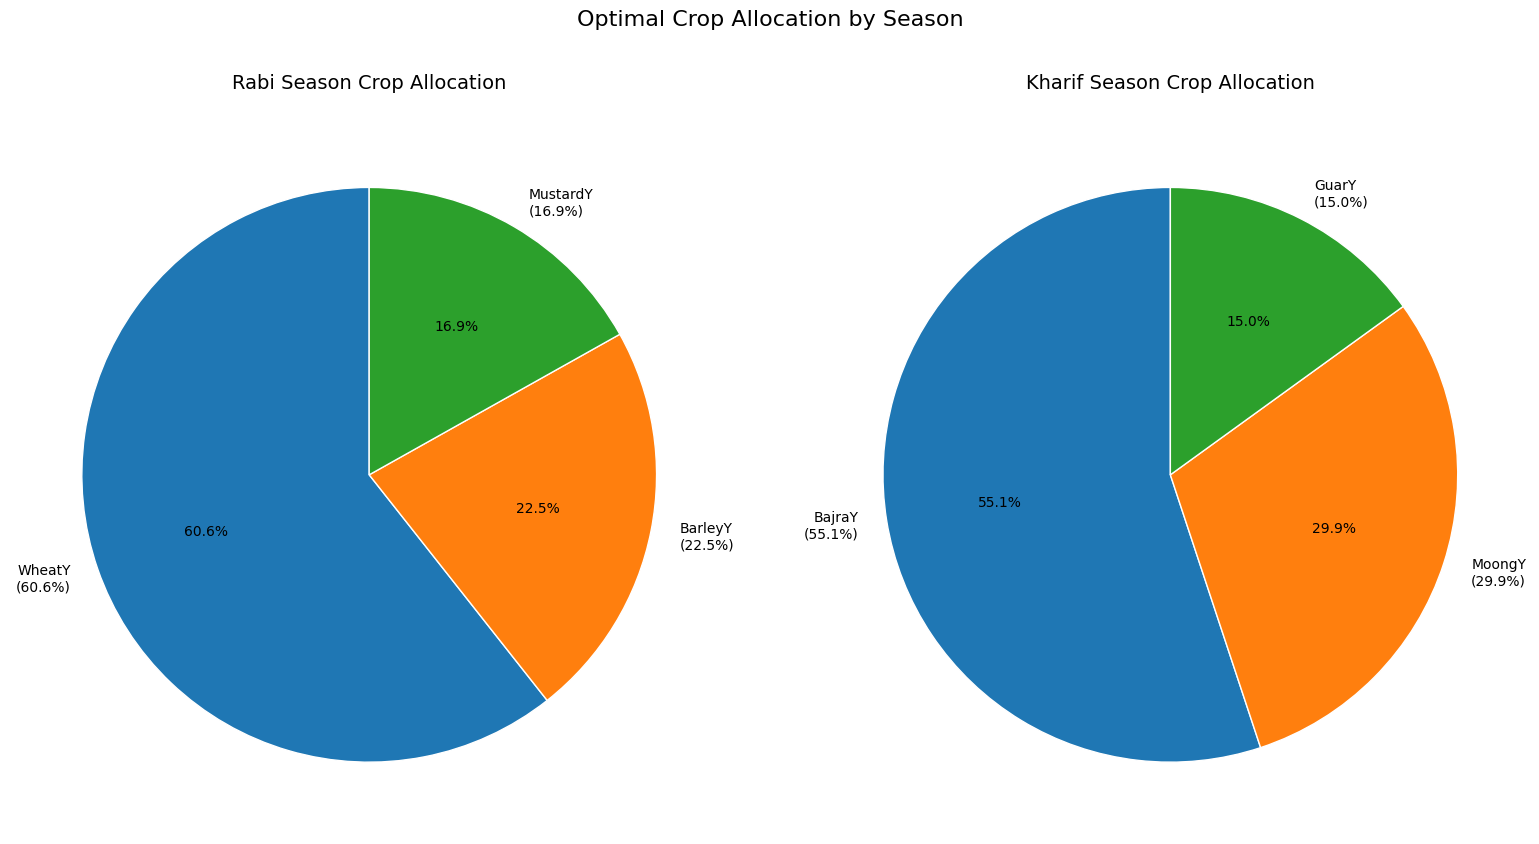

In [8]:
import matplotlib.pyplot as plt
def enhanced_plot_allocation(x):
    rabi_total = np.sum(x * rabi_mask)
    kharif_total = np.sum(x * kharif_mask)
    
    rabi_total = max(rabi_total, 1e-10)
    kharif_total = max(kharif_total, 1e-10)
    
    normalized = x.copy()
    normalized[rabi_mask == 1] = x[rabi_mask == 1] / rabi_total
    normalized[kharif_mask == 1] = x[kharif_mask == 1] / kharif_total
    rabi_data = [(crop, normalized[i]) 
                for i, crop in enumerate(crop_yields) if rabi_mask[i]]
    kharif_data = [(crop, normalized[i]) 
                  for i, crop in enumerate(crop_yields) if kharif_mask[i]]
    rabi_data.sort(key=lambda x: x[1], reverse=True)
    kharif_data.sort(key=lambda x: x[1], reverse=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    rabi_labels = [f"{crop}\n({perc:.1%})" for crop, perc in rabi_data]
    rabi_sizes = [perc for crop, perc in rabi_data]
    ax1.pie(rabi_sizes, labels=rabi_labels, autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax1.set_title('Rabi Season Crop Allocation', pad=20, fontsize=14)
    kharif_labels = [f"{crop}\n({perc:.1%})" for crop, perc in kharif_data]
    kharif_sizes = [perc for crop, perc in kharif_data]
    ax2.pie(kharif_sizes, labels=kharif_labels, autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax2.set_title('Kharif Season Crop Allocation', pad=20, fontsize=14)
    plt.suptitle('Optimal Crop Allocation by Season', y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

enhanced_plot_allocation(best_x)

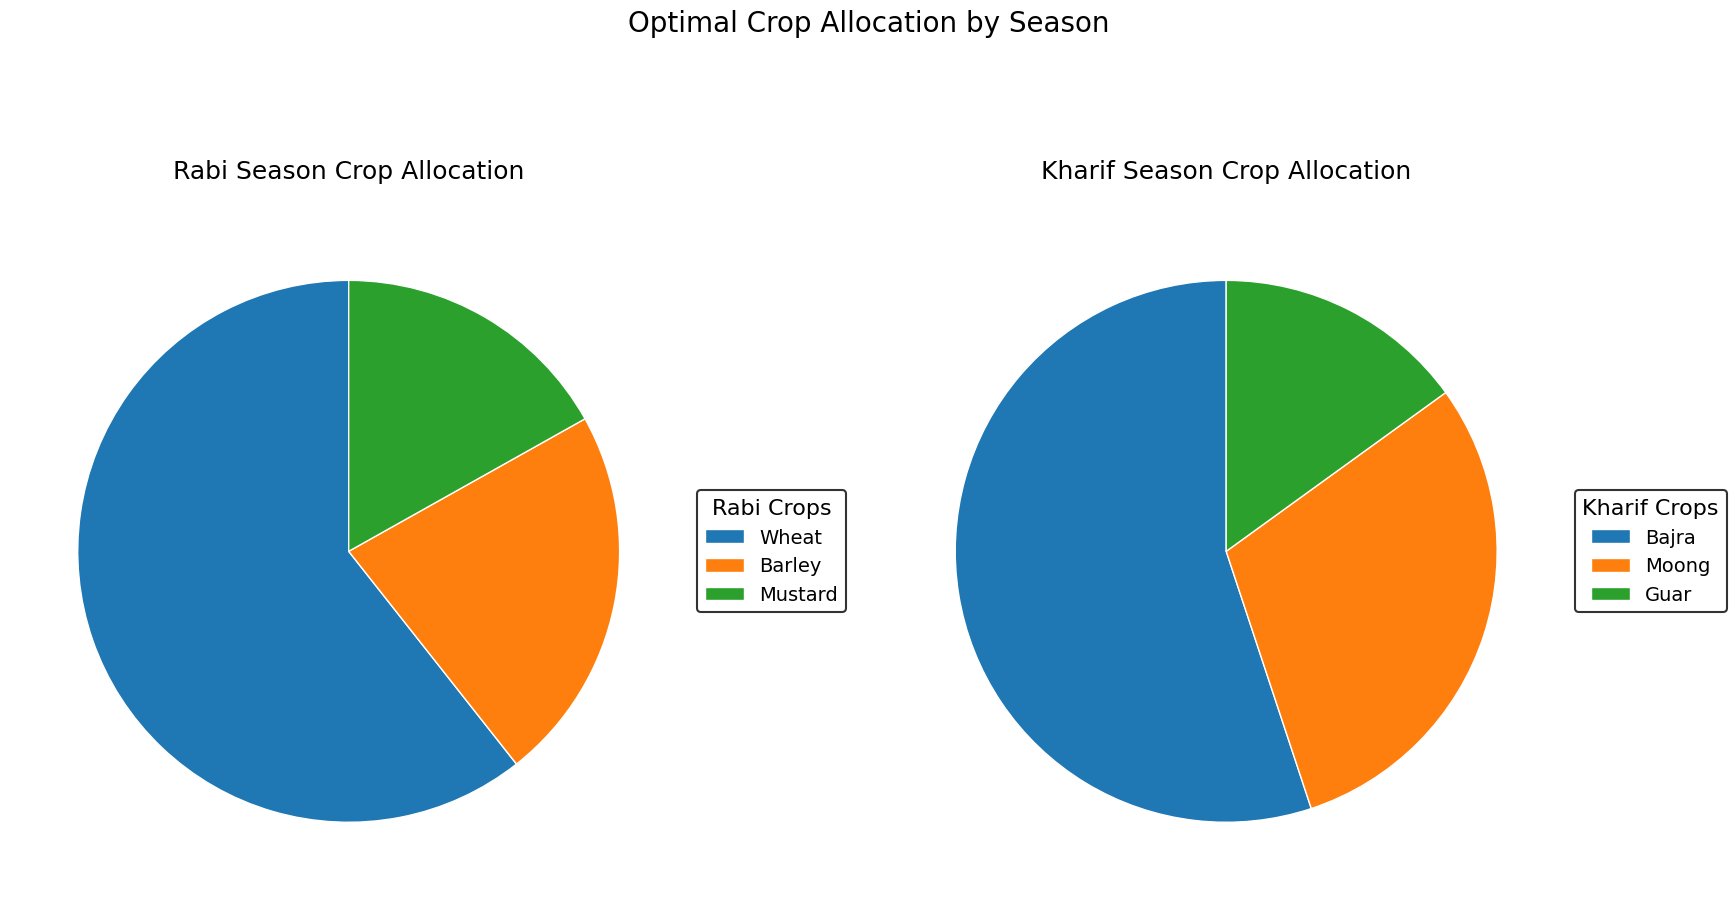

In [9]:
def enhanced_plot_allocation(x):
    crop_name_map = {
        'BajraY': 'Bajra',
        'WheatY': 'Wheat',
        'MustardY': 'Mustard',
        'BarleyY': 'Barley',
        'GuarY': 'Guar',
        'MoongY': 'Moong'
    }
    
    rabi_total = np.sum(x * rabi_mask)
    kharif_total = np.sum(x * kharif_mask)
    
    rabi_total = max(rabi_total, 1e-10)
    kharif_total = max(kharif_total, 1e-10)
    
    normalized = x.copy()
    normalized[rabi_mask == 1] = x[rabi_mask == 1] / rabi_total
    normalized[kharif_mask == 1] = x[kharif_mask == 1] / kharif_total
    
    rabi_data = [(crop_name_map[crop_yields[i]], normalized[i]) 
                for i in range(len(crop_yields)) if rabi_mask[i]]
    kharif_data = [(crop_name_map[crop_yields[i]], normalized[i]) 
                  for i in range(len(crop_yields)) if kharif_mask[i]]
    
    rabi_data.sort(key=lambda x: x[1], reverse=True)
    kharif_data.sort(key=lambda x: x[1], reverse=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), dpi=100)
    title_fontsize = 18
    legend_fontsize = 14
    label_fontsize = 16
    
    # Rabi pie chart
    rabi_labels = [crop for crop, perc in rabi_data]
    rabi_sizes = [perc for crop, perc in rabi_data]
    rabi_colors = ['#1f77b4','#ff7f0e','#2ca02c']
    ax1.pie(rabi_sizes, colors=rabi_colors, startangle=90,
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax1.set_title('Rabi Season Crop Allocation', pad=25, fontsize=title_fontsize)
    
    # Kharif pie chart
    kharif_labels = [crop for crop, perc in kharif_data]
    kharif_sizes = [perc for crop, perc in kharif_data]
    kharif_colors = ['#1f77b4','#ff7f0e','#2ca02c']
    ax2.pie(kharif_sizes, colors=kharif_colors, startangle=90,
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax2.set_title('Kharif Season Crop Allocation', pad=25, fontsize=title_fontsize)
    
    # Add legends with larger text
    rabi_legend = ax1.legend(rabi_labels, title="Rabi Crops", 
                           loc="center left", bbox_to_anchor=(1, 0.5),
                           prop={'size': legend_fontsize},
                           title_fontsize=label_fontsize)
    kharif_legend = ax2.legend(kharif_labels, title="Kharif Crops", 
                             loc="center left", bbox_to_anchor=(1, 0.5),
                             prop={'size': legend_fontsize},
                             title_fontsize=label_fontsize)
    
    # Set legend frame properties
    for legend in [rabi_legend, kharif_legend]:
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(1.5)
    
    # Add overall title with larger font
    plt.suptitle('Optimal Crop Allocation by Season', y=1.05, fontsize=20)
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.show()

# Plot enhanced visualization
enhanced_plot_allocation(best_x)

In [10]:
F= res.F
X = res.X

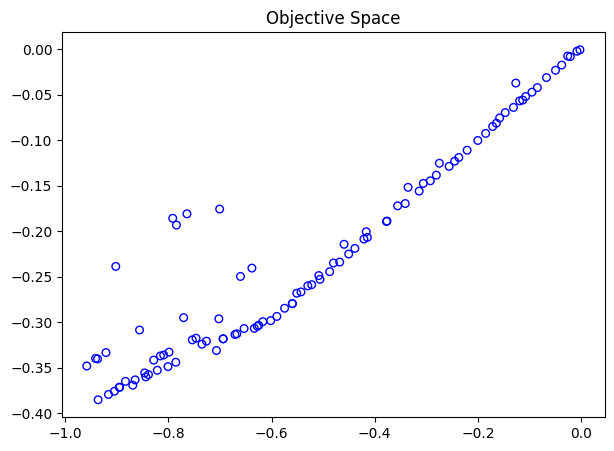

In [11]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [12]:
fl = F.min(axis=0)
fu = F.max(axis=0)

print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [-0.9585027367933429, -0.0019292448688808643]
Scale f2: [-0.38527939598293554, -0.0007754953718196116]


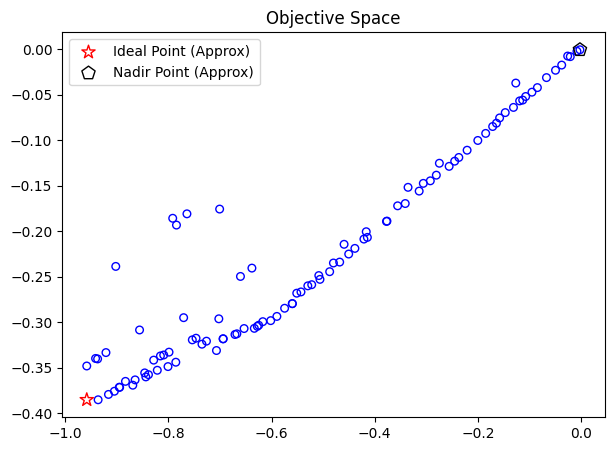

In [13]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()

Scale f1: [0.0, 1.0]
Scale f2: [0.0, 1.0]


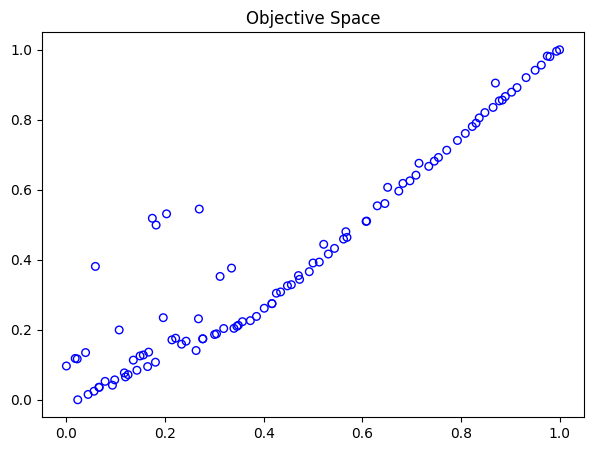

In [14]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

plt.figure(figsize=(7, 5))
plt.scatter(nF[:, 0], nF[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

Best regarding Pseudo Weights: Point 
i = 95
F = [-0.63348914 -0.30680589  0.34533817]


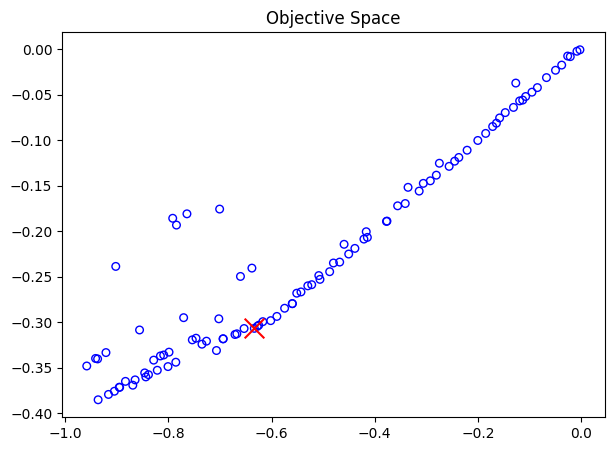

In [15]:
from pymoo.decomposition.asf import ASF
from pymoo.mcdm.pseudo_weights import PseudoWeights
weights = np.array([0.2, 0.5, 0.3])  # Adjusted to match the number of objectives

decomp = ASF()
i = PseudoWeights(weights).do(nF)
print("Best regarding Pseudo Weights: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

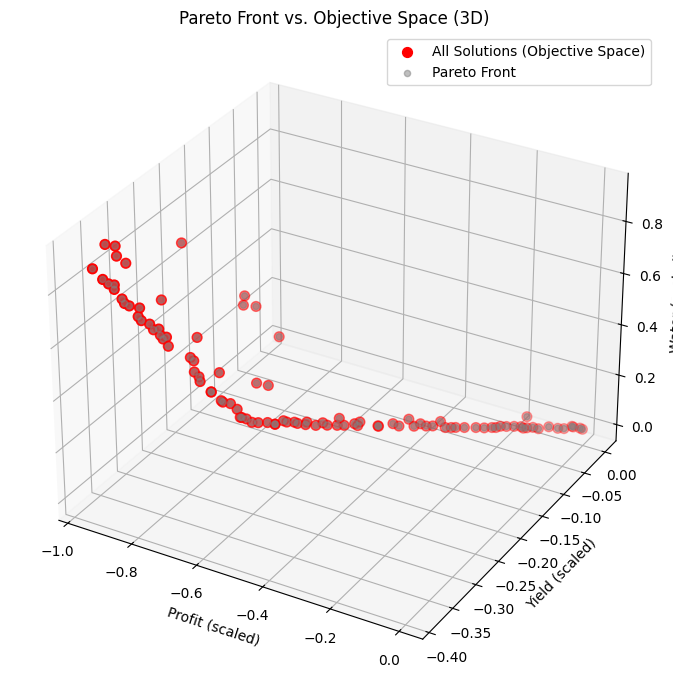

In [16]:
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

# Get the final population (includes dominated solutions)
final_pop = res.pop

# Extract objective values for all solutions in the population
all_F = np.array([ind.F for ind in final_pop])

# Pareto front (non-dominated solutions)
pareto_front = res.F

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot all solutions (objective space, gray)
ax.scatter(all_F[:, 0], all_F[:, 1], all_F[:, 2], 
           c='red', s=50, label="All Solutions (Objective Space)")

# Plot Pareto front (red)
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], 
           c='grey', alpha=0.5, label="Pareto Front")

# Labels and title
ax.set_xlabel("Profit (scaled)")
ax.set_ylabel("Yield (scaled)")
ax.set_zlabel("Water (scaled)")
ax.set_title("Pareto Front vs. Objective Space (3D)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from pymoo.optimize import minimize

X, F = res.opt.get("X", "F")

hist = res.history
print(len(hist))


100


In [18]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

At least one feasible solution in Generation 0 after 100 evaluations.
Whole population feasible in Generation 4 after 500 evaluations.


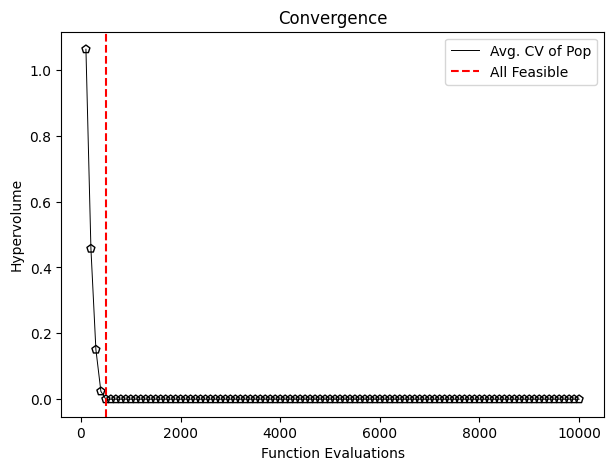

In [19]:
k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

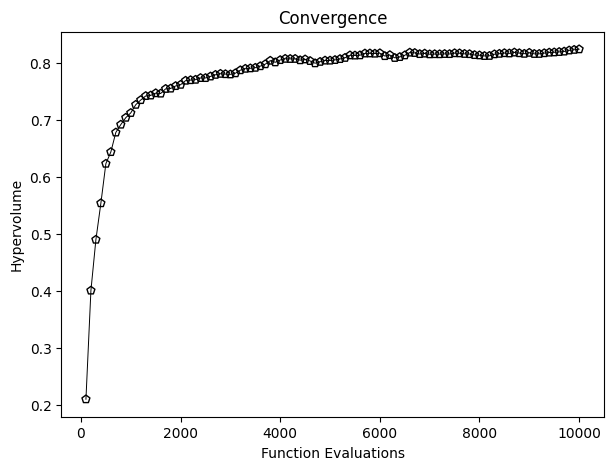

In [20]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
from pymoo.indicators.hv import Hypervolume

# Ensure the ref_point matches the number of objectives (3 in this case)
metric = Hypervolume(ref_point=np.array([1.1, 1.1, 1.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

In [21]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
front = NonDominatedSorting().do(res.F)[0]
pareto_solutions = res.F[front]
profit = -pareto_solutions[:, 0] / problem.obj_scaling[0]  # Note: Negative sign was used for maximization
yield_ = -pareto_solutions[:, 1] / problem.obj_scaling[1]
water = pareto_solutions[:, 2] / problem.obj_scaling[2]
pareto_allocations = res.X[front]

In [22]:
rabi_total = np.sum(pareto_allocations * rabi_mask, axis=1)
kharif_total = np.sum(pareto_allocations * kharif_mask, axis=1)
dominant_season = np.where(rabi_total > kharif_total, "Rabi", "Kharif")

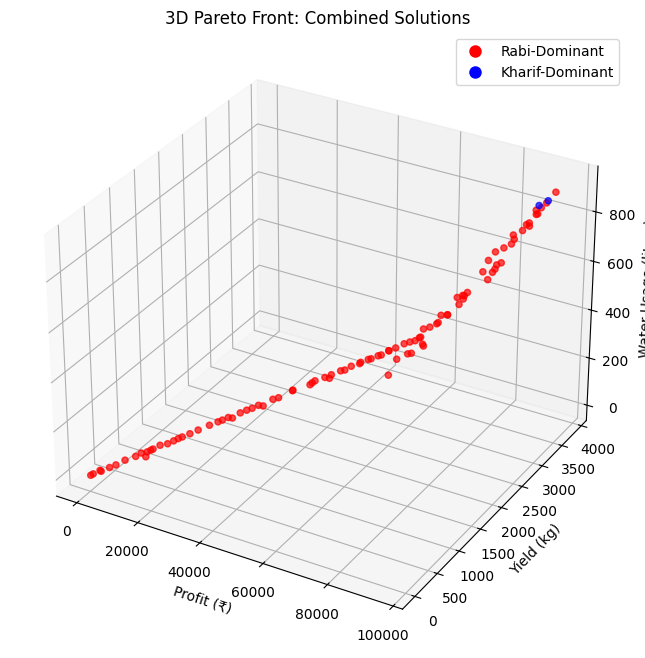

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    profit, yield_, water, 
    c=np.where(dominant_season == "Rabi", "red", "blue"),
    alpha=0.7,
    label=dominant_season
)

ax.set_xlabel("Profit (₹)")
ax.set_ylabel("Yield (kg)")
ax.set_zlabel("Water Usage (liters)")
ax.set_title("3D Pareto Front: Combined Solutions")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Rabi-Dominant'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Kharif-Dominant')
])
plt.show()

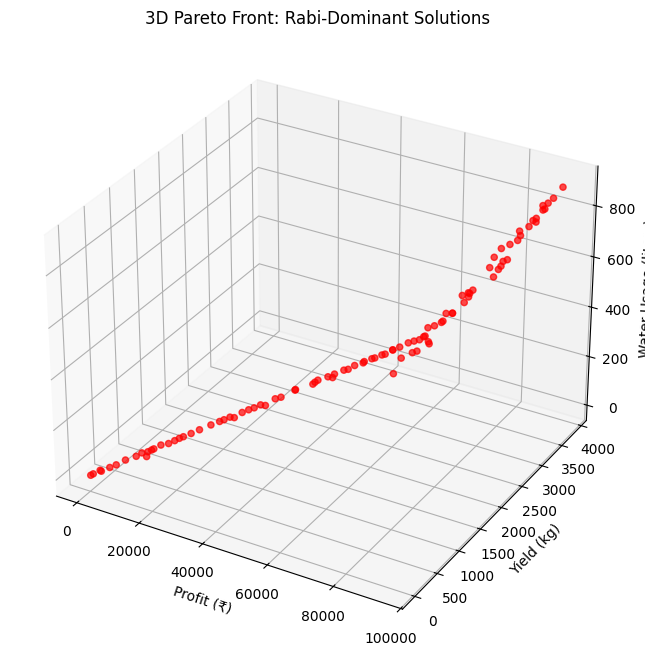

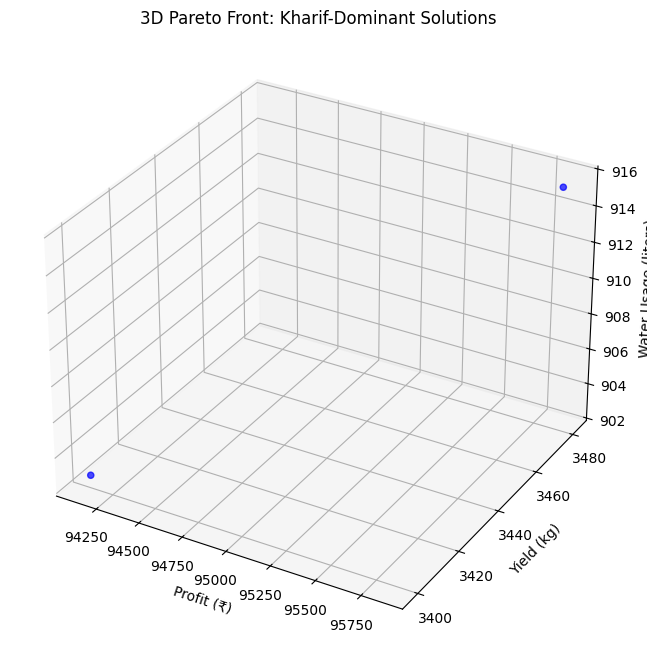

In [24]:
# Rabi-Dominant Solutions
rabi_mask = dominant_season == "Rabi"
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(profit[rabi_mask], yield_[rabi_mask], water[rabi_mask], c='red', alpha=0.7)
ax.set_xlabel("Profit (₹)"); ax.set_ylabel("Yield (kg)"); ax.set_zlabel("Water Usage (liters)")
ax.set_title("3D Pareto Front: Rabi-Dominant Solutions")
plt.show()

# Kharif-Dominant Solutions
kharif_mask = dominant_season == "Kharif"
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(profit[kharif_mask], yield_[kharif_mask], water[kharif_mask], c='blue', alpha=0.7)
ax.set_xlabel("Profit (₹)"); ax.set_ylabel("Yield (kg)"); ax.set_zlabel("Water Usage (liters)")
ax.set_title("3D Pareto Front: Kharif-Dominant Solutions")
plt.show()